In [1]:
from imagem import Imagem
from glob import glob
import Functions as fc
import numpy as np
from skimage.io import imread,imshow,imsave,imread_collection
import cv2
from skimage.exposure import equalize_hist
from skimage.filters import median
from IPython.display import clear_output
from tqdm import tqdm
import seaborn as sns
import time
from sklearn.decomposition import PCA
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split

In [2]:
originais = sorted(glob(f'./imagens/*/*', recursive=True))

imgs = {
    'daisy': sorted(glob(f'./imagens/daisy/*', recursive=True)),
    'dandelion': sorted(glob(f'./imagens/dandelion/*', recursive=True)),
    'rose': sorted(glob(f'./imagens/rose/*', recursive=True)),
    'sunflower': sorted(glob(f'./imagens/sunflower/*', recursive=True)),
    'tulip': sorted(glob(f'./imagens/tulip/*', recursive=True))
}

In [3]:
def poeInt(imagem):
    linhas, colunas = imagem.shape
    copy = np.zeros((linhas, colunas), dtype=np.uint8)
    for l in range(linhas):
        for c in range(colunas):
                if imagem[l][c] == True:
                    copy[l][c] = 255
    return copy

In [4]:
def lerTodos(originais):
    imgs = []
    for i in tqdm(originais, desc='Imagens:  '):
        img = Imagem(i)
        img.ler()
        img.filtros['eq'] = img.equalize()
        img.filtros['median'] = median(img.filtros['eq'] )
        #img.filtros['otsu'] = fc.aplicaOtsu(img.filtros['median'])
        imgs.append(img)
    
    
    return imgs

In [5]:
def subtraiCamada(img, camada='b'):
    img0 = img.filtros['median'].copy()
    img0 = img0/255
    img0 = img0[:,:,0] + img0[:,:,1] + img0[:,:,2]

    img1 = img.filtros['otsu'][camada].copy()
    img1 = img1/255

    img0[~img1.astype(bool)] = 0
    
    return img0

In [6]:
def subtrai(imgs):
    for i in tqdm(imgs, desc='Otsu:  '):
        i.filtros['otsu'] = {
            'r': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,0])),
            'g': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,1])),
            'b': poeInt(fc.aplicaOtsu(i.filtros['median'][:,:,2]))
        }

        i.filtros['inteiro'] = i.inteiro()

        i.filtros['normalize'] = i.normalize()

        i.filtros['sub'] = {
            'r': subtraiCamada(i, 'r'),
            'g': subtraiCamada(i, 'g'),
            'b': subtraiCamada(i, 'b')
        }

        """ 
            Fazer a subtração dos canais de cor com o otsu.     
        """
    
    return imgs


In [7]:
imagens = lerTodos(originais)

Imagens:  : 100%|██████████| 500/500 [00:42<00:00, 11.89it/s]


In [8]:
imagens = subtrai(imagens)

Otsu:  : 100%|██████████| 500/500 [01:18<00:00,  6.37it/s]


/home/matheus/.local/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


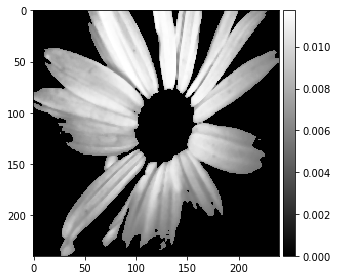

In [15]:
imshow(imagens[5].filtros['sub']['b'], cmap='gray')

In [18]:
auxR = [ imagens[x].filtros['sub']['b'] for x in range(len(imagens)) ]
auxG = [ imagens[x].filtros['sub']['g'] for x in range(len(imagens)) ]
auxB = [ imagens[x].filtros['sub']['r'] for x in range(len(imagens)) ]

In [12]:
""" imagens[0].salvar(auxR, originais, caminho='./subs/red')
imagens[0].salvar(auxG, originais, caminho='./subs/green')
imagens[0].salvar(auxB, originais, caminho='./subs/blue') """

In [19]:
red = imread_collection(sorted(glob(f'./subs/red/*/*', recursive=True)))
green = imread_collection(sorted(glob(f'./subs/green/*/*', recursive=True)))
blue = imread_collection(sorted(glob(f'./subs/blue/*/*', recursive=True)))

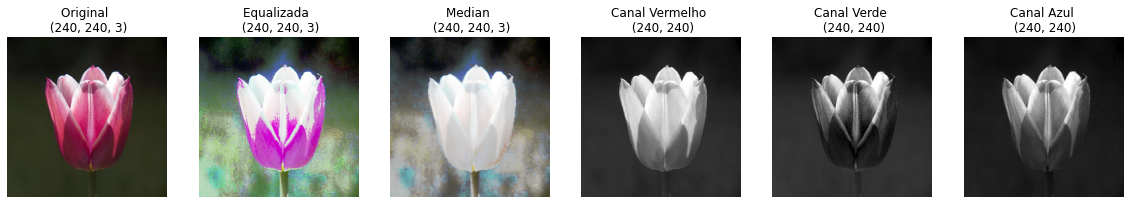

In [27]:
imagens[440].shows(5)

In [28]:
labels = []
labelsInt = []
k = 0
for j in ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']:
    for i in range(100):
        labels.append(j)
        labelsInt.append(k)
    k += 1

---
# Descritores

In [29]:
def aplicaGLCM(images, labels):
    features = np.zeros((len(labels),18)) #6 features x 3 color channels
    start = time.time()
    d = 5
    for id_im,imagem in enumerate(images):
        clear_output(wait=True)
        print('Extraindo atributos: {} imagens processadas de {}.'.format(id_im+1,len(images)))
        for id_ch in range(3):
            matrix0 = greycomatrix(imagem[:,:,id_ch], [d], [0],normed=True)
            matrix1 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/4],normed=True)
            matrix2 = greycomatrix(imagem[:,:,id_ch], [d], [np.pi/2],normed=True)
            matrix3 = greycomatrix(imagem[:,:,id_ch], [d], [3*np.pi/4],normed=True)
            matrix = (matrix0+matrix1+matrix2+matrix3)/4 
            props = np.zeros((6))
            props[0] = greycoprops(matrix,'contrast')
            props[1] = greycoprops(matrix,'dissimilarity')
            props[2] = greycoprops(matrix,'homogeneity')
            props[3] = greycoprops(matrix,'energy')
            props[4] = greycoprops(matrix,'correlation')
            props[5] = greycoprops(matrix,'ASM')
            features[id_im,id_ch*6:(id_ch+1)*6] = props

    end = time.time()
    tempo = end - start
    clear_output(wait=True)
    return features, tempo

In [ ]:
rRed, tempo = aplicaGLCM(red, labels)
rGreen, tempo = aplicaGLCM(green, labels)
rBlue, tempo = aplicaGLCM(blue, labels)

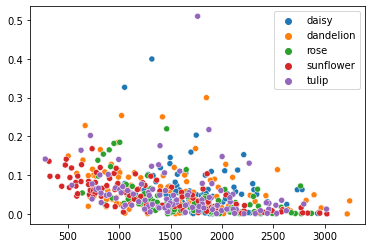

In [36]:
sns.scatterplot(x=rRed[:,0], y=rRed[:,5], hue=labels);

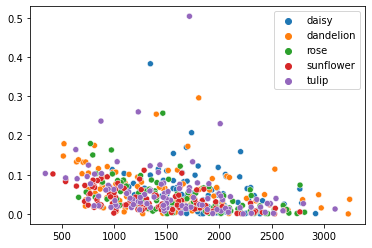

In [35]:
sns.scatterplot(x=rGreen[:,0], y=rGreen[:,5], hue=labels);

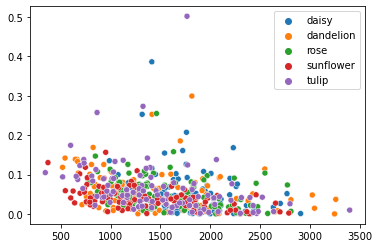

In [34]:
sns.scatterplot(x=rBlue[:,0], y=rBlue[:,5], hue=labels);

In [37]:
def aplicaPCA(features):
    pca = PCA()
    pca.fit(features)
    transform = pca.transform(features)
    print(np.sum(pca.explained_variance_ratio_[0:3]))
    return transform

In [38]:
transRed = aplicaPCA(rRed)
transGreen = aplicaPCA(rGreen)
transBlue = aplicaPCA(rBlue)

0.9999983544615109
0.9999990357781031
0.999998853121441


# Classification

- Dividir o espaço de atributos em regiões;
- A quantidade de regiões é o número de classes;
- A acurácia da classificação está diretamente liga à qualidade dos atributos.

### Train/Test

In [39]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer, confusion_matrix,accuracy_score
from sklearn.svm import SVC

In [40]:
def classificationForest(X,y, t=0.9):
    """ com random forest """
    # separar conjuntos de treino e teste
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True, random_state=42)
    # criar instancia do classificador
    clf = RandomForestClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [41]:
def classificationXBR(X, y, t=0.9):
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=t,shuffle=True)
    # criar instancia do classificador
    clf = xgb.XGBClassifier()
    # treinar o classificador
    clf.fit(X_train,y_train)
    # realizar a predicao
    pred = clf.predict(X_test)
    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)
    return acuracia

In [42]:
rRedAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rRedAc.append(
        {
            "Original": {
                'rf': classificationForest(rRed, labelsInt, t=i),
                'xbr': classificationXBR(rRed, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transRed, labelsInt, t=i),
                'xbr': classificationXBR(transRed, labelsInt, t=i)
            }
        }
    )

rRedAc

[{'Original': {'rf': 0.435, 'xbr': 0.435},
  'Transform': {'rf': 0.53, 'xbr': 0.48}},
 {'Original': {'rf': 0.41333333333333333, 'xbr': 0.43333333333333335},
  'Transform': {'rf': 0.5266666666666666, 'xbr': 0.5533333333333333}},
 {'Original': {'rf': 0.51, 'xbr': 0.48},
  'Transform': {'rf': 0.55, 'xbr': 0.59}},
 {'Original': {'rf': 0.48, 'xbr': 0.54},
  'Transform': {'rf': 0.58, 'xbr': 0.48}}]

In [43]:
rGreenAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rGreenAc.append(
        {
            "Original": {
                'rf': classificationForest(rGreen, labelsInt, t=i),
                'xbr': classificationXBR(rGreen, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transGreen, labelsInt, t=i),
                'xbr': classificationXBR(transGreen, labelsInt, t=i)
            }
        }
    )

rGreenAc

[{'Original': {'rf': 0.375, 'xbr': 0.39},
  'Transform': {'rf': 0.575, 'xbr': 0.52}},
 {'Original': {'rf': 0.44, 'xbr': 0.4533333333333333},
  'Transform': {'rf': 0.58, 'xbr': 0.5466666666666666}},
 {'Original': {'rf': 0.44, 'xbr': 0.48},
  'Transform': {'rf': 0.54, 'xbr': 0.62}},
 {'Original': {'rf': 0.56, 'xbr': 0.48},
  'Transform': {'rf': 0.56, 'xbr': 0.48}}]

In [44]:
rBlueAc = []
for i in [0.6, 0.7, 0.8, 0.9]:
    rBlueAc.append(
        {
            "Original": {
                'rf': classificationForest(rBlue, labelsInt, t=i),
                'xbr': classificationXBR(rBlue, labelsInt, t=i)
            },
            "Transform": {
                'rf': classificationForest(transBlue, labelsInt, t=i),
                'xbr': classificationXBR(transBlue, labelsInt, t=i)
            }
        }
    )

rBlueAc

[{'Original': {'rf': 0.47, 'xbr': 0.485},
  'Transform': {'rf': 0.55, 'xbr': 0.565}},
 {'Original': {'rf': 0.5, 'xbr': 0.4533333333333333},
  'Transform': {'rf': 0.5933333333333334, 'xbr': 0.5933333333333334}},
 {'Original': {'rf': 0.44, 'xbr': 0.52},
  'Transform': {'rf': 0.56, 'xbr': 0.52}},
 {'Original': {'rf': 0.48, 'xbr': 0.52},
  'Transform': {'rf': 0.54, 'xbr': 0.6}}]

# Grid Seach

In [45]:
def aplicaGS_randomForest(imgs, labels, test_size=0.20):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = RandomForestClassifier()

    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [100,110,120,150,200]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 5
        #n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [46]:
def aplicaGS_xbr(imgs, labels, test_size=0.2):
    #para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test_size, random_state=42)

    #criar instancia do classificador
    clf = xgb.XGBClassifier()



    #definir os parametros a serem testados
    param_grid = {
        'n_estimators': [100,110,120,150,200]
    }

    #criar instancia do grid search
    grid = GridSearchCV(
        clf,
        param_grid,
        scoring = 'accuracy',
        cv = 5
        #n_jobs=-1
    )

    #treinar o classificador
    grid.fit(x_train, y_train)

    return grid.best_params_

In [48]:
redParams = {
    'rf': aplicaGS_randomForest(rRed, labelsInt),
    'xbr': aplicaGS_xbr(rRed, labelsInt),
    'rf_transform': aplicaGS_randomForest(transRed, labelsInt),
    'xbr_transform': aplicaGS_xbr(transRed, labelsInt)
}

greenParams = {
    'rf': aplicaGS_randomForest(rGreen, labelsInt),
    'xbr': aplicaGS_xbr(rGreen, labelsInt),
    'rf_transform': aplicaGS_randomForest(transGreen, labelsInt),
    'xbr_transform': aplicaGS_xbr(transGreen, labelsInt)
}

blueParams = {
    'rf': aplicaGS_randomForest(rBlue, labelsInt),
    'xbr': aplicaGS_xbr(rBlue, labelsInt),
    'rf_transform': aplicaGS_randomForest(transBlue, labelsInt),
    'xbr_transform': aplicaGS_xbr(transBlue, labelsInt)
}

In [50]:
redParams,greenParams,blueParams

({'rf': {'n_estimators': 120},
  'xbr': {'n_estimators': 110},
  'rf_transform': {'n_estimators': 200},
  'xbr_transform': {'n_estimators': 100}},
 {'rf': {'n_estimators': 200},
  'xbr': {'n_estimators': 150},
  'rf_transform': {'n_estimators': 100},
  'xbr_transform': {'n_estimators': 200}},
 {'rf': {'n_estimators': 100},
  'xbr': {'n_estimators': 100},
  'rf_transform': {'n_estimators': 200},
  'xbr_transform': {'n_estimators': 200}})

# Cross Validation

## Random Forest

In [52]:
def crossValidationRF(imgs, labels, bestPrms, test=0.3):
    # para treinar o classificador
    x_train, x_test, y_train, y_test = train_test_split(imgs,labels, test_size=test, random_state=42)
    
    # criar instancia do classificador
    clf = RandomForestClassifier(n_estimators=bestPrms['rf']['n_estimators'])
    
    # treinar o classificador
    clf.fit(x_train, y_train)

    # realizar a predicao
    pred = clf.predict(x_test)

    # calcular o resultado utilizando a acuracia
    acuracia = acc(y_test,pred)

    # Criar as métricas
    metrics = ['accuracy','precision_macro','recall_macro','f1_macro']

    # Criar o dicionário de resultados
    scores_rf = cross_validate(clf, imgs, labels, cv=5, scoring=metrics)

    # Criar o dicionário de resultados
    kappa = make_scorer(cohen_kappa_score)

    
    scores_rf_kappa = cross_validate(clf,imgs,labels,cv=5, scoring=kappa)


    clear_output(wait=True)


    return acuracia, scores_rf, scores_rf_kappa

#### RED

In [54]:
acRf_Red, scoresRf_Red, scoresRfKappa_Red = crossValidationRF(rRed, labelsInt, redParams)

In [56]:
acRf_Red

0.4533333333333333

In [57]:
scoresRf_Red

{'fit_time': array([0.14082742, 0.13094187, 0.13741851, 0.12915111, 0.13298178]),
 'score_time': array([0.00728774, 0.0072577 , 0.00763988, 0.00739884, 0.00822401]),
 'test_accuracy': array([0.42, 0.4 , 0.43, 0.43, 0.48]),
 'test_precision_macro': array([0.40022083, 0.40794258, 0.44931735, 0.39784679, 0.45357466]),
 'test_recall_macro': array([0.42, 0.4 , 0.43, 0.43, 0.48]),
 'test_f1_macro': array([0.40709368, 0.40373626, 0.42173637, 0.40935444, 0.46193458])}

In [58]:
scoresRfKappa_Red

{'fit_time': array([0.13212872, 0.13513231, 0.13254404, 0.13015294, 0.13105392]),
 'score_time': array([0.0071609 , 0.00850272, 0.0067811 , 0.00741816, 0.00739741]),
 'test_score': array([0.3125, 0.2875, 0.275 , 0.3125, 0.375 ])}

In [59]:
scoresRfKappa_Red['test_score'].mean(), scoresRfKappa_Red['test_score'].std()

(0.3125, 0.034460121880225555)

#### GREEN

In [60]:
acRf_Green, scoresRf_Green, scoresRfKappa_Green = crossValidationRF(rGreen, labelsInt, greenParams)

In [61]:
acRf_Green

0.4066666666666667

In [62]:
scoresRf_Green

{'fit_time': array([0.20975614, 0.20247054, 0.21251464, 0.22854567, 0.25070906]),
 'score_time': array([0.01110387, 0.01129293, 0.01241612, 0.01231003, 0.01189017]),
 'test_accuracy': array([0.39, 0.38, 0.43, 0.44, 0.36]),
 'test_precision_macro': array([0.37945925, 0.37075224, 0.43508541, 0.4359707 , 0.33154081]),
 'test_recall_macro': array([0.39, 0.38, 0.43, 0.44, 0.36]),
 'test_f1_macro': array([0.37669977, 0.37434875, 0.43153232, 0.43080024, 0.34255531])}

In [63]:
scoresRfKappa_Green

{'fit_time': array([0.21213889, 0.21449876, 0.21660399, 0.23154116, 0.22262383]),
 'score_time': array([0.01105905, 0.01061416, 0.01222539, 0.0110445 , 0.01278853]),
 'test_score': array([0.2375, 0.15  , 0.275 , 0.2375, 0.2125])}

In [64]:
scoresRfKappa_Green['test_score'].mean(), scoresRfKappa_Green['test_score'].std()

(0.22250000000000006, 0.04138236339311713)

#### BLUE

In [65]:
acRf_Blue, scoresRf_Blue, scoresRfKappa_Blue = crossValidationRF(rBlue, labelsInt, blueParams)

In [66]:
acRf_Blue

0.44666666666666666

In [67]:
scoresRf_Blue

{'fit_time': array([0.11739969, 0.10082817, 0.10398364, 0.10046697, 0.10337472]),
 'score_time': array([0.00600743, 0.00671124, 0.0064013 , 0.00687981, 0.00606775]),
 'test_accuracy': array([0.45, 0.42, 0.42, 0.47, 0.45]),
 'test_precision_macro': array([0.45111111, 0.41544137, 0.45737879, 0.48682195, 0.43706111]),
 'test_recall_macro': array([0.45, 0.42, 0.42, 0.47, 0.45]),
 'test_f1_macro': array([0.45002506, 0.41512205, 0.43396825, 0.46396723, 0.44048435])}

In [68]:
scoresRfKappa_Blue

{'fit_time': array([0.10523629, 0.10533881, 0.10604358, 0.10918474, 0.11104417]),
 'score_time': array([0.00542951, 0.00680661, 0.00586319, 0.00571823, 0.00613236]),
 'test_score': array([0.4125, 0.2875, 0.25  , 0.3125, 0.2625])}

In [69]:
scoresRfKappa_Blue['test_score'].mean(), scoresRfKappa_Blue['test_score'].std()

(0.305, 0.057879184513951125)